# ARMseq Pipeline

Getting ARMseq pipeline to work. Yeast data.

Note: not all commands can be excuted from this script. See Preliminaries

In [2]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')

In [3]:
library(dplyr)
library(rtracklayer)
library(ggplot2)
library(Rsamtools)
library(Biostrings)
library(seqinr)
library(parallel)
options(mc.cores = 24)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: GenomicRanges
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste

In [4]:
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/seqtools.R")

SHA-1 hash of file is 7565259173739547b4f1cbdfab1ca6430db08508


In [5]:
genome = read.fasta("/g/steinmetz/genome/Saccharomyces_cerevisiae/S288c_ERCC/ver_20150412/fasta/S288c_complete_wERCC.fsa")

## Preliminaries

First you must download ARMseq datasets with SRA toolkit (`fastq-dump`), cut adapter sequences with `cutadapt`, and then align, sort, and index the reads using `bowtie2`. [This](processANDalign.txt) bash script does these steps. Final output are bam files.

## Remapping in R

In [6]:
# working directory
setwd("/g/steinmetz/project/IESY/trna/ARMseq/")

### Load tRNA annotations from [GtRNAdb](http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/)

*Extend upstream and downstream regions with `window` parameter*

In [7]:
window = 50

tRNA_annotations = read.delim(
    "../ARMseq/data/tRNA_isoforms_wleaders_4R.txt", sep = "\t", header = T, strip.white=TRUE)
# switch start / end when end < start. denote strand instead
tRNA_annotations = data.frame(do.call(rbind, apply(tRNA_annotations, 1, function(i){
    #print(i["Start"])
    if (i["Chr"] == "chrM") {
        i["Chr"] = "chrMT"
    }
    if (as.numeric(i["Start"]) < as.numeric(i["End"])) {
        o = i
        # modify upstream/downstream sequences based on window of interest
        o$Upstream = paste(genome[[i["Chr"]]][seq((as.numeric(i["Start"]) - window),
                                                          (as.numeric(i["Start"]) - 1))], collapse = "")
        o$Downstream = paste(genome[[i["Chr"]]][seq((as.numeric(i["End"]) + 1),
                                                          (as.numeric(i["End"]) + window))], collapse = "")
        o$Start = as.numeric(i["Start"])
        o$End = as.numeric(i["End"])
        o$Strand = "+"
    } else {
        o = i
        # modify upstream/downstream sequences based on window of interest
        o$Upstream = tolower(as.character(reverseComplement(DNAString(paste(genome[[i["Chr"]]][seq((as.numeric(i["Start"]) + 1),
                                                          (as.numeric(i["Start"]) + window))], collapse = "")))))
        o$Downstream = tolower(as.character(reverseComplement(DNAString(paste(genome[[i["Chr"]]][seq((as.numeric(i["End"]) - window),
                                                          (as.numeric(i["End"]) - 1))], collapse = "")))))
        o$Start = as.numeric(i["End"])
        o$End = as.numeric(i["Start"])
        o$Strand = "-"
    }
    return(o)
})))
tRNA_annotations$Start = as.numeric(tRNA_annotations$Start)
tRNA_annotations$End = as.numeric(tRNA_annotations$End)
tRNA_annotations$End = as.numeric(tRNA_annotations$End)
tRNA_annotations$tRNA.Number = as.numeric(tRNA_annotations$tRNA.Number)
tRNA_annotations$tRNA.type = as.character(tRNA_annotations$tRNA.type)
tRNA_annotations$Anticodon = unlist(tRNA_annotations$Anticodon)

In [8]:
head(tRNA_annotations)

,Chr,tRNA.Number,Start,End,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand
1,chrIV,3,410379,410451,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+
2,chrVI,6,204924,204996,Ala,AGC,tgtaaagtaaacctgtatcatttctgtttggaagatttcaacaaacgttc,tttaaatttttttattttttttgtcaaatctctctatctatagagataat,0,0,74.48,50.69,23.79,Bo,-
3,chrVII,15,774349,774421,Ala,AGC,ttagatttacttcattattcttctctattctcccctttcatcaattaatt,aatttttttacttttaatgaggtatactggaatattacggctcttttttt,0,0,74.48,50.69,23.79,Bo,+
4,chrVIII,8,146242,146314,Ala,AGC,acactccggtattactcgagcccgtaatacaacacattcaacaaatatca,atcttttttgttattaccataacagtactataaaggtctgttaatgtata,0,0,74.48,50.69,23.79,Bo,-
5,chrX,22,197313,197385,Ala,AGC,tgtcatactgacgtatctcactttgataaacaacaatatcaataatatta,atttctttttgttctcaacgacaataataagaaaatcaacttaaatggaa,0,0,74.48,50.69,23.79,Bo,-
6,chrXI,4,219895,219967,Ala,AGC,taaaagagcttgttatagtaatctaagtggaaatacactaacagtaaata,atctttttatacttattaataatttttttcctgccgttacttgcttttaa,0,0,74.48,50.69,23.79,Bo,+


### Extract only reads aligned to these regions from bam files

*Steps*
1. Make GRanges object
2. Convert to RangesList
3. Use `scanBam` from `Rsamtools` to extract alignments
4. Process bam file so that it can be combined with tRNA table above

In [9]:
window2 = 50

gr <- GRanges(
    seqnames = Rle(unlist(tRNA_annotations$Chr)),
    ranges = IRanges(start = tRNA_annotations$Start - window2,
                 end = tRNA_annotations$End + window2),
    strand = Rle(unlist(tRNA_annotations$Strand)),
    mcols = select(tRNA_annotations, tRNA.Number,tRNA.type, Upstream, Downstream)
)

In [10]:
gr_list = RangesList(lapply(seq(1,length(gr)),function(i){ranges(gr[i,])}))
names(gr_list) = seqnames(gr)

Import bam files for the following samples/alignments:

- AlkB treated
- AlkB trated with very-sensitive, end-to-end alignment
- Untreated
- Untreated with very-sensitive, end-to-end alignment

In [11]:
fdir = "/g/steinmetz/project/IESY/trna/ARMseq/data/" # where are the bam files
what = c("qname", "rname", "strand", "pos", "mapq", "cigar", "seq", "qual") # what to access from alignments
tags = c("AS", "XS", "NM")
param = ScanBamParam(which = gr_list, what = what, tag = tags)


untreated <- scanBam(paste0(fdir,"untreated.bam"), param=param, 
               index = paste0(fdir,"untreated.bam.bai"))
#untreated_vse2e <- scanBam(paste0(fdir,"untreated_vse2e.bam"), param=param, 
#               index = paste0(fdir,"untreated_vse2e.bam.bai"))
# alkB <- scanBam(paste0(fdir,"treated.bam"), param=param, 
#                index = paste0(fdir,"treated.bam.bai"))
# alkB_vse2e <- scanBam(paste0(fdir,"treated_vse2e.bam"), param=param, 
#                index = paste0(fdir,"treated_vse2e.bam.bai"))

Warning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecatedWarning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecated

Alter bam data.frame to make it compatible with tRNA data.frame

In [12]:
untreated = makeHappyBam(untreated, tRNA_annotations)
#untreated_vse2e = makeHappyBam(untreated_vse2e, tRNA_annotations)
#alkB = makeHappyBam(alkB)
#alkB_vse2e = makeHappyBam(alkB_vse2e)

### Try to assign counts for all reads (tRNAs)

In [13]:
mapped_reads = untreated
anticodon = "AGC"
tRNA_annotations = tRNA_annotations
anticodon_tRNAs = filter(tRNA_annotations, Anticodon %in% anticodon)
tRNA_read = merge(anticodon_tRNAs, mapped_reads, by = c("Chr","Start","End"))
x = tRNA_read

#head(filterMature(x %>% filter(qname = "SRR1874045.362855"), clean = T, flip = F))

x %>% filter(qname == "SRR1874045.292256")

,Chr,Start,End,tRNA.Number,tRNA.type,Anticodon,Upstream,Downstream,Intron.Start,Intron.End,Cove,HMM,X2pStr,Hit.Origin,Strand,qname,rname,strand,pos,mapq,cigar,seq,qual,AS,XS,NM
1,chrIV,410379,410451,3,Ala,AGC,ttaagtgcaaacatgtaagaaagattctcggtaacgaccatacaaatatt,aattattttttactttccgcggtgccgagatgcagacgtggccaactgtg,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.292256,chrIV,+,410430,0,25M,GGTTCGATTCCGGACTCGTCCACTA,BCABBCCFFFFFGGGGGGGGGEHHH,-15,NA,3
2,chrVI,204924,204996,6,Ala,AGC,tgtaaagtaaacctgtatcatttctgtttggaagatttcaacaaacgttc,tttaaatttttttattttttttgtcaaatctctctatctatagagataat,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrVI,-,204921,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-10,NA,2
3,chrVII,774349,774421,15,Ala,AGC,ttagatttacttcattattcttctctattctcccctttcatcaattaatt,aatttttttacttttaatgaggtatactggaatattacggctcttttttt,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.292256,chrVII,+,774400,0,25M,GGTTCGATTCCGGACTCGTCCACTA,BCABBCCFFFFFGGGGGGGGGEHHH,-15,NA,3
4,chrVIII,146242,146314,8,Ala,AGC,acactccggtattactcgagcccgtaatacaacacattcaacaaatatca,atcttttttgttattaccataacagtactataaaggtctgttaatgtata,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrVIII,-,146239,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-10,NA,2
5,chrX,197313,197385,22,Ala,AGC,tgtcatactgacgtatctcactttgataaacaacaatatcaataatatta,atttctttttgttctcaacgacaataataagaaaatcaacttaaatggaa,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrX,-,197310,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-10,NA,2
6,chrXI,219895,219967,4,Ala,AGC,taaaagagcttgttatagtaatctaagtggaaatacactaacagtaaata,atctttttatacttattaataatttttttcctgccgttacttgcttttaa,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.292256,chrXI,+,219946,0,25M,GGTTCGATTCCGGACTCGTCCACTA,BCABBCCFFFFFGGGGGGGGGEHHH,-10,NA,2
7,chrXI,517988,518060,9,Ala,AGC,gtaaaaatatatgatccaattcctaggacatcagaaaatatatctactat,ttttaaaatttctttttttttttttctctttccgtatgtaagcttttttc,0,0,74.48,50.69,23.79,Bo,+,SRR1874045.292256,chrXI,+,518039,0,25M,GGTTCGATTCCGGACTCGTCCACTA,BCABBCCFFFFFGGGGGGGGGEHHH,-10,NA,2
8,chrXII,656934,657006,16,Ala,AGC,tatcatactgacgtaccccattctgaaacacaacagacaacaagaaaatt,agtaaatattttttgcaacttcttcaacctccaattattattcgatcatt,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrXII,-,656931,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-15,NA,3
9,chrXIII,321147,321219,17,Ala,AGC,tatcctacatttatgttttctatacttcttcaaagtcttcaatacaaatc,ttttttatttttttggctaactaacccatatataacgtcttttacgaggt,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrXIII,-,321144,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-10,NA,2
10,chrXIII,768369,768441,9,Ala,AGC,ttttaaactgatttcactttttacagtggctagaaattacaataagaaat,aattttttgctactttgcaattagtgtaacttcatatttaaaattatagt,0,0,74.48,50.69,23.79,Bo,-,SRR1874045.292256,chrXIII,-,768366,0,25M,TAGTGGACGAGTCCGGAATCGAACC,HHHEGGGGGGGGGFFFFFCCBBACB,-15,NA,3


In [ ]:
tmp = assignReads(untreated, tRNA_annotations, anticodon = "GCC", useBam = F, returnCounts = F)

In [ ]:
tmp2 = assignReads(untreated, tRNA_annotations, anticodon = "GCC", useBam = T, returnCounts = F)

In [15]:
tmp3 = merge(data.frame(table(tmp$read)), data.frame(table(tmp2$read)), by = "Var1")

In [30]:
tmp %>% filter(read == "SRR1874045.292256")

,score,read,chr,tRNA.start
1,1.990687,SRR1874045.292256,chrIV,410379
2,1.990687,SRR1874045.292256,chrVI,204924
3,1.990687,SRR1874045.292256,chrVII,774349
4,1.990687,SRR1874045.292256,chrVIII,146242
5,1.990687,SRR1874045.292256,chrX,197313
6,1.990687,SRR1874045.292256,chrXI,219895
7,1.990687,SRR1874045.292256,chrXI,517988
8,1.990687,SRR1874045.292256,chrXII,656934
9,1.990687,SRR1874045.292256,chrXIII,321147
10,1.990687,SRR1874045.292256,chrXIII,768369


In [31]:
tmp2 %>% filter(read == "SRR1874045.292256")

,score,read,chr,tRNA.start
1,-10,SRR1874045.292256,chrVI,204924
2,-10,SRR1874045.292256,chrVIII,146242
3,-10,SRR1874045.292256,chrX,197313
4,-10,SRR1874045.292256,chrXI,219895
5,-10,SRR1874045.292256,chrXI,517988
6,-10,SRR1874045.292256,chrXIII,321147
7,-10,SRR1874045.292256,chrXVI,856902


In [16]:
cor(tmp3$Freq.x, tmp3$Freq.y, method = "spearman")

[1] 0.998397

In [18]:
tmp4 = merge(tmp, tmp2, by = "read")

In [19]:
#head(tmp4)

In [20]:
#tmp5 = filter(tmp4, read %in% names(which(table(tmp4$read) > 1))) 
#tmp5[with(tmp5, order(-score.x, read)), ][1:19,]

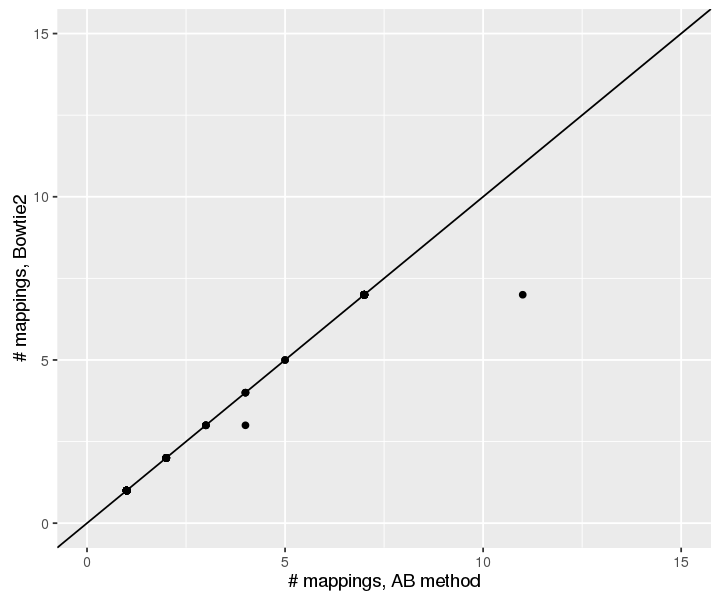

In [21]:
ggplot(tmp3,aes(Freq.x, Freq.y)) + geom_point() +
    #geom_smooth(method = "lm", se = FALSE, color = "black", lwd = .2, formula = y ~ 0 + x) +
    geom_abline(slope = 1,intercept = 0) +
    xlab("# mappings, AB method") + ylab("# mappings, Bowtie2") + xlim(c(0,15)) + ylim(c(0,15))

# Plots

In [ ]:
#  check distribution of all mapping points to the tRNA locus
distance_dist = apply(cbind(abs(untreated$pos - untreated$Start), 
                            abs(untreated$pos - untreated$End)),1,min)
options(repr.plot.width = 8)
options(repr.plot.height = 4)
plot(ecdf(distance_dist), main = "Distance of read start to mature tRNA start/stop", 
     xlab = "Nucleotides")

### Does the number of pre-tRNA reads scale with the # of reads aligning to mature sequence only?

Note that this estimate could be off because I am missing reads that map to mature tRNA sequences with modifications. To get these I would need to run ARMseq pipeline

In [ ]:
all_merged = merge(tRNA_annotations, untreated, by = c("Chr","Start","End"))
tRNA_read_filtered = filterMature(all_merged, flip = F)
tRNA_read_others = filterMature(all_merged, flip = T)

In [ ]:
nonpre = tRNA_read_others  %>% group_by(Anticodon) %>% do({data.frame(.$tRNA.type[1], counts = length(unique(.$qname)))})
pre = tRNA_read_filtered  %>% group_by(Anticodon) %>% do({data.frame(.$tRNA.type[1], counts = length(unique(.$qname)))})

In [ ]:
preANDnonpre = merge(pre,nonpre,by="Anticodon")

In [ ]:
ggplot(filter(preANDnonpre, counts.x < 15000), aes(x = counts.x, y = counts.y)) + 
    geom_point(aes(color = ..tRNA.type.1..x)) + 
    geom_smooth(method = "lm", se = FALSE, color = "black", lwd = .2, formula = y ~ 0 + x) +
    xlab("# pre-tRNA Reads") + ylab("# mature tRNA reads") +
    xlim(c(0,1000)) + ylim(c(0,1000))